In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import Xception, VGG16
from tensorflow.keras.layers import Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [7]:
!dir /content/drive/MyDrive/*.h5

dir: cannot access '/content/drive/MyDrive/*.h5': No such file or directory


## 필수 : 런타임 -> 런타임 유형변경 -> GPU

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install wget

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=10193f9f56583d0c1aebdfa1f1e341003d3774ad389a67e8a98418c1a777f547
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget


In [ ]:
# '''
# cats_and_dogs_filtered 데이터셋은 25,000개의 이미지를 포함하는 원본 Dogs Vs. Cats 데이터셋에서 약 3,000개의 이미지를 추출한 간소화된 버전의 데이터셋입니다.

# '''
# import wget

# url = "https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip"
# wget.download(url) # 현재 폴더에 파일 다운로드

'cats_and_dogs_filtered.zip'

In [ ]:
# 현재 폴더에 파일이 있는지 확인
# !dir cat*.zip

cats_and_dogs_filtered.zip


In [ ]:
# import os
# base_path="./content/cats_and_dogs_filtered/"
# os.path.exists(base_path)  # 작업 디렉토리는 cats_and_dogs_filtered

False

In [ ]:
import os
import shutil

if os.path.exists(base_path):    #작업디렉토리가 존재하면 내용을 삭제함
    
    shutil.rmtree(base_path)
    print(base_path,'  is removed !!!')
else:
    os.makedirs(base_path)    #작업디렉토리가 없으면 생성함
    print(base_path,' is MAKED !!!')

./content/cats_and_dogs_filtered/  is MAKED !!!


In [ ]:
# 압축파일 풀기

# import zipfile
# #현재디렉토리에 있는 cats_and_dogs_filtered.zip 을 작업 디렉토리에 압축해제한다
# with zipfile.ZipFile('./cats_and_dogs_filtered.zip', 'r') as target_file: 

#     target_file.extractall(base_path)  # ./content/cats_and_dogs_filtered/

In [ ]:
IMG_WIDTH = 224
IMG_HEIGHT = 224

In [ ]:
base_model = VGG16(weights='imagenet', 
                   include_top=False, # 기존 출력층(10개분류) 안쓰고 내가 정하는 분류층을 정의할 예정
                   input_shape=(IMG_WIDTH,IMG_HEIGHT,3))

base_model.summary()

58900480/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [ ]:
# 처리층 정의
model = Sequential()

model.add(base_model) # 기존층 추가

model.add(Flatten()) # 결과를 1차원으로 늘려놓고

model.add(Dense(16, activation='relu')) # 16개층으로 (층 개수에 따라 성능이 바뀐다.)
model.add(Dropout(0.25)) # 날려버리기 너무 학습 많이 하면 힘듬(?)

model.add(Dense(2, activation='softmax')) #최종출력은  2개, [0일 확률 1일 확률] 형태로 반환

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 16)                401424    
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 2)                 34        
                                                                 
Total params: 15,116,146
Trainable params: 15,116,146
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# 개, 고양이 두개만 구분하기 위해 앞에 20몇개의 층을 업데이트(가중치)할 필요 x
print('base_model를 동결 전 학습 가중치 변수 층 수:', 
      len(model.trainable_weights)) 

base_model를 동결 전 학습 가중치 변수 층 수: 30


In [ ]:
base_model.trainable = False # 기존 파라미터 학습 수정 안함. 학습 잠구기

In [ ]:
print('conv_base를 동결 후 학습 가중치 변수 층 수:', 
      len(model.trainable_weights)) # 학습할 층 갯수 출력

conv_base를 동결 후 학습 가중치 변수 층 수: 4


In [ ]:
# ImageDataGenerator 이용하여 데이터 불러옴
# 훈련용만 사진 변형
# 테스트는 그대로
train_data_gen = ImageDataGenerator(rescale=1./255, 
                                    rotation_range=10, 
                                    width_shift_range=0.1, 
                                    height_shift_range=0.1, 
                                    shear_range=0.1, 
                                    zoom_range=0.1)

test_data_gen = ImageDataGenerator(rescale=1./255)

In [ ]:
train_dir = '/content/drive/MyDrive/kb_datasets/사과_토마토/train/'

test_dir = '/content/drive/MyDrive/kb_datasets/사과_토마토/test/'

class_mode='categorical' 이면 정답은 one-hot encoding 됨.  
class_mode='binary' 이면 정답은 0,1 됨.  
class_mode='softmax' 이면 정답은 여러개의 확률이 반환됨.

In [ ]:
train_data = train_data_gen.flow_from_directory(train_dir, batch_size=32, 
                                                color_mode='rgb', 
                                                shuffle=True, 
                                                class_mode='categorical',
                                                target_size=(IMG_WIDTH,IMG_HEIGHT))


test_data = test_data_gen.flow_from_directory(test_dir, batch_size=32, 
                                              color_mode='rgb', 
                                              shuffle=True, 
                                              class_mode='categorical',
                                              target_size=(IMG_WIDTH,IMG_HEIGHT))

Found 125 images belonging to 2 classes.
Found 24 images belonging to 2 classes.


In [ ]:
# 정답 확인

print(train_data.class_indices.items())
print(test_data.class_indices.items())

print(len(train_data.classes))
print(len(test_data.classes))

print(train_data.num_classes)
print(test_data.num_classes)

dict_items([('구글사과', 0), ('구글토마토', 1)])
dict_items([('구글사과', 0), ('구글토마토', 1)])
125
24
2
2


In [ ]:
# 모델 컴파일

# model.compile(loss='categorical_crossentropy', 
model.compile(loss='binary_crossentropy', 
              optimizer=tf.keras.optimizers.Adam(2e-5), metrics=['accuracy'])

In [ ]:
train_data.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [ ]:
train_data.num_classes

2

In [ ]:
train_data.labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [ ]:
from datetime import datetime
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

save_file_name = './cats_and_dogs_filtered_VGG16_Colab.h5'

# 현재 학습중인 weight값을 저장해주는 객체 (callback 클래스)
checkpoint = ModelCheckpoint(save_file_name,       
                             monitor='val_loss',   
                             verbose=1, # 저장시 메세지 출력
                             save_best_only=True,  # val_loss가 가장 낮을때마다 저장
                             mode='auto'           
                            )

earlystopping = EarlyStopping(monitor='val_loss',  
                              patience=5,          
                             )

start_time = datetime.now()

hist = model.fit(train_data, 
                #  epochs=30, 
                 epochs=10, 
                 validation_data=test_data,
                 callbacks=[checkpoint, earlystopping])

end_time = datetime.now()

print('elapsed time = ', end_time-start_time)

Epoch 1/10
4/4 [==============================] - ETA: 0s - loss: 0.6958 - accuracy: 0.6240 
Epoch 1: val_loss improved from inf to 0.63781, saving model to ./cats_and_dogs_filtered_VGG16_Colab.h5
4/4 [==============================] - 86s 24s/step - loss: 0.6958 - accuracy: 0.6240 - val_loss: 0.6378 - val_accuracy: 0.7083
Epoch 2/10
4/4 [==============================] - ETA: 0s - loss: 0.6607 - accuracy: 0.6400
Epoch 2: val_loss improved from 0.63781 to 0.62442, saving model to ./cats_and_dogs_filtered_VGG16_Colab.h5
4/4 [==============================] - 2s 550ms/step - loss: 0.6607 - accuracy: 0.6400 - val_loss: 0.6244 - val_accuracy: 0.7083
Epoch 3/10
4/4 [==============================] - ETA: 0s - loss: 0.6564 - accuracy: 0.6560
Epoch 3: val_loss improved from 0.62442 to 0.61245, saving model to ./cats_and_dogs_filtered_VGG16_Colab.h5
4/4 [==============================] - 2s 549ms/step - loss: 0.6564 - accuracy: 0.6560 - val_loss: 0.6124 - val_accuracy: 0.8333
Epoch 4/10
4/4 [=

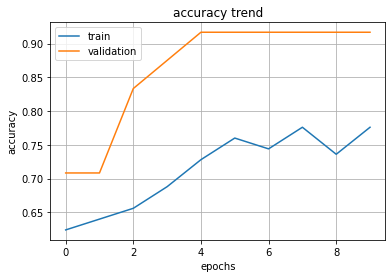

In [ ]:
import matplotlib.pyplot as plt

plt.title('accuracy trend')
plt.grid()
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.plot(hist.history['accuracy'], label='train')
plt.plot(hist.history['val_accuracy'], label='validation')
plt.legend(loc='best')
plt.show()

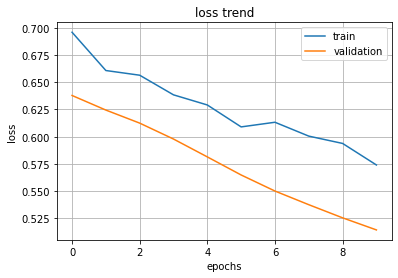

In [ ]:
import matplotlib.pyplot as plt

plt.title('loss trend')
plt.grid()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='validation')
plt.legend(loc='best')
plt.show()

In [ ]:
import os
import shutil

if os.path.exists('./content/test_image_dir/'):    
    
    shutil.rmtree('./content/test_image_dir/')
    print('./content/test_image_dir/  is removed !!!')
else:
    os.makedirs('./content/test_image_dir/')
    print('./content/test_image_dir/  is MAKED !!!')    

./content/test_image_dir/  is MAKED !!!


In [ ]:
# 압축파일 풀기 - 테스트용 고양이,강아지 이미지는 직접 다운로드해야함.

import zipfile

# with zipfile.ZipFile('./content/test_image_dir.zip', 'r') as target_file:
with zipfile.ZipFile('./test_image_dir.zip', 'r') as target_file:

    target_file.extractall('./content/test_image_dir/') 

In [ ]:
import cv2
import glob

test_img_list = []

test_img_name_list = glob.glob('/content/drive/MyDrive/kb_datasets/사과_토마토/test2/*')

for i in range(len(test_img_name_list)):

    src_img = cv2.imread(test_img_name_list[i], cv2.IMREAD_COLOR)
    src_img = cv2.resize(src_img, dsize=(IMG_WIDTH, IMG_HEIGHT))

    dst_img = cv2.cvtColor(src_img, cv2.COLOR_BGR2RGB)

    dst_img = dst_img / 255.0

    test_img_list.append(dst_img)

print(test_img_name_list)
print(len(test_img_list))

['/content/drive/MyDrive/kb_datasets/사과_토마토/test2/images (12).jpeg', '/content/drive/MyDrive/kb_datasets/사과_토마토/test2/images (4).jpeg', '/content/drive/MyDrive/kb_datasets/사과_토마토/test2/images (21).jpeg', '/content/drive/MyDrive/kb_datasets/사과_토마토/test2/images (22).jpeg', '/content/drive/MyDrive/kb_datasets/사과_토마토/test2/다운로드 (11).jpeg', '/content/drive/MyDrive/kb_datasets/사과_토마토/test2/images (26).jpeg', '/content/drive/MyDrive/kb_datasets/사과_토마토/test2/다운로드 (1).jpeg', '/content/drive/MyDrive/kb_datasets/사과_토마토/test2/다운로드 (2).jpeg', '/content/drive/MyDrive/kb_datasets/사과_토마토/test2/다운로드 (3).jpeg', '/content/drive/MyDrive/kb_datasets/사과_토마토/test2/다운로드 (4).jpeg', '/content/drive/MyDrive/kb_datasets/사과_토마토/test2/다운로드 (5).jpeg', '/content/drive/MyDrive/kb_datasets/사과_토마토/test2/다운로드.jpeg', '/content/drive/MyDrive/kb_datasets/사과_토마토/test2/다운로드 (6).jpeg', '/content/drive/MyDrive/kb_datasets/사과_토마토/test2/images (7).jpeg', '/content/drive/MyDrive/kb_datasets/

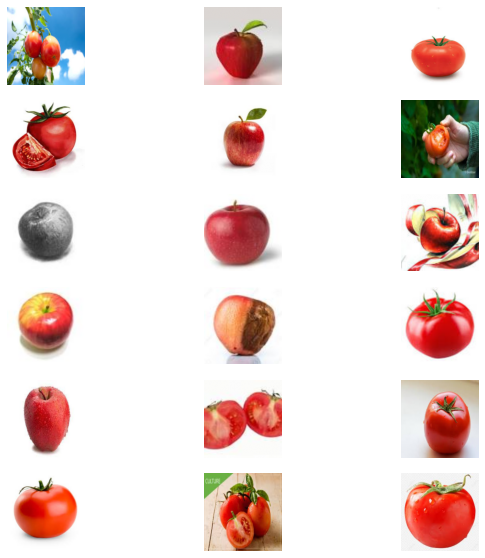

In [ ]:
plt.figure(figsize=(10,10))

for i in range(len(test_img_list)):

    plt.subplot(6, 3, i+1)
    plt.axis('off')
    plt.imshow(test_img_list[i])

plt.show()

In [ ]:
for i in range(len(test_img_list)):

    print(test_img_list[i].shape)

(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


In [ ]:
# predict 수행하기 위해 batch 차원 추가
import numpy as np

print(np.array(test_img_list).shape)

(18, 224, 224, 3)


In [ ]:
# predict 실행

# dict_items([('구글사과', 0), ('구글토마토', 1)])
class_name = [ 'apple', 'tomato' ]  # ImageDataGenerator 에서 apple=0, tomato=1

pred = model.predict(np.array(test_img_list))

print(pred.shape)
print(pred)

(18, 2)
[[0.27712876 0.72287124]
 [0.49209458 0.5079054 ]
 [0.3972319  0.6027681 ]
 [0.32219064 0.67780936]
 [0.659207   0.340793  ]
 [0.4077525  0.5922475 ]
 [0.8034972  0.1965028 ]
 [0.68135035 0.31864965]
 [0.6212569  0.37874317]
 [0.70189476 0.29810527]
 [0.66742676 0.3325732 ]
 [0.30954906 0.6904509 ]
 [0.85701126 0.14298874]
 [0.16960527 0.83039474]
 [0.41894117 0.5810588 ]
 [0.472921   0.527079  ]
 [0.5964429  0.40355712]
 [0.5558802  0.44411978]]


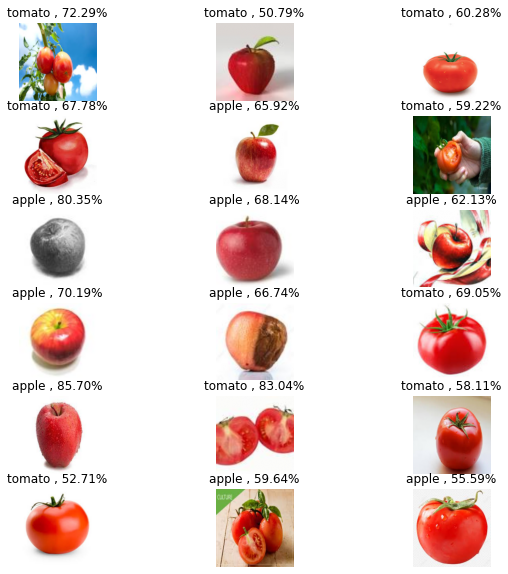

In [ ]:
class_name = [ 'apple', 'tomato' ]  # ImageDataGenerator 에서 apple=0, tomato=1

plt.figure(figsize=(10,10))

for i in range(len(pred)):

    plt.subplot(6, 3, i+1)
    prediction = str(class_name[np.argmax(pred[i])])
    probility = '{0:0.2f}'.format(100*max(pred[i]))
    title_str = prediction + ' , ' + probility + '%'
    plt.axis('off')
    plt.title(title_str)
    plt.imshow(test_img_list[i])

plt.show()